<a href="https://colab.research.google.com/github/colincockburn/CISC_473_project/blob/main/image_restoration_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import yaml
import os
from dotenv import load_dotenv

load_dotenv()

REPO_DIR = os.getenv("REPO_DIR")
DATA_ROOT = os.getenv("DATA_ROOT")
SAVE_DIR = os.getenv("SAVE_DIR")
CKPT_PATH = f"{os.getenv("SAVE_DIR")}/best.pth"

sys.path.append(REPO_DIR)

with open(f"{REPO_DIR}/configs/default.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [4]:
# run training

import sys
from src.train import main
from pathlib import Path

Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

sys.argv = [
    "train.py",
    "--data_root", DATA_ROOT,
    "--save_dir", SAVE_DIR,
    "--epochs", "10",
    "--batch_size", "16",
    "--patch_size", "128",
    "--lr", "1e-3"
]

main()

starting loop


KeyboardInterrupt: 

In [ ]:
# Evaluation

import sys
from pathlib import Path
from src.eval import main as eval_main

# Ensure paths exist
assert Path(DATA_ROOT).exists(), f"Dataset not found: {DATA_ROOT}"
assert Path(CKPT_PATH).exists(), f"Checkpoint not found: {CKPT_PATH}"

# Simulate CLI args
sys.argv = [
    "eval.py",
    "--data_root", DATA_ROOT,
    "--ckpt_path", CKPT_PATH,
    "--batch_size", "8",
    "--num_workers", "2",
    "--patch_size", "128"
]

# Run evaluation
eval_main()


Using device: cpu
Loaded checkpoint: /home/colin/projects/CISC_473_project/checkpoints/run1/best.pth


Evaluating: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


 Evaluation Results:
Loss : 0.001425
PSNR : 28.93 dB
SSIM : 0.9121


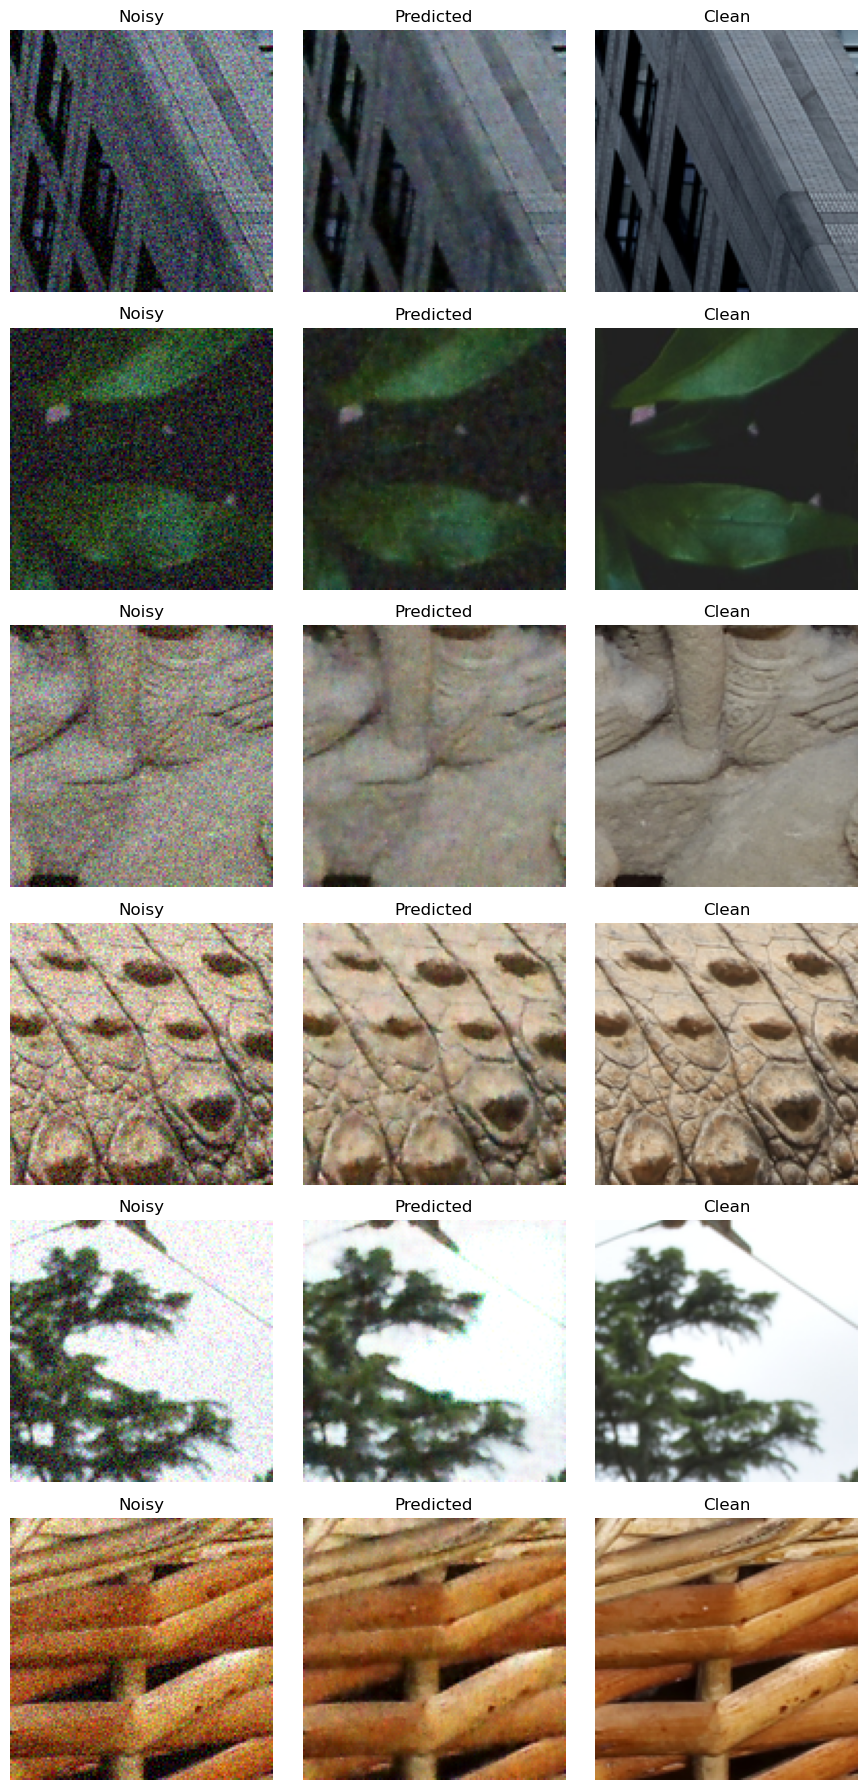

In [ ]:
# disply results
import torch
import matplotlib.pyplot as plt
from src.model import UNetDenoise
from src.data import Div2kDataSet
from torch.utils.data import DataLoader
import random

# --- Config ---
num_samples = 6 # number of rows to show
patch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load model ---
model = UNetDenoise(in_ch=3, out_ch=3, base_ch=64).to(device)
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

# --- Validation data (patch mode) ---
val_set = Div2kDataSet(root=DATA_ROOT, split="valid",
                       patch_size=patch_size, sigma=25.0, augment=False)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

# --- Pick random samples ---
samples = random.sample(range(len(val_set)), num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(9, 3 * num_samples))
axes = axes if num_samples > 1 else [axes]

for i, idx in enumerate(samples):
    noisy, clean = val_set[idx]
    noisy = noisy.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(noisy)
    
    # Convert to numpy [H,W,3]
    def to_np(t): return t.squeeze(0).permute(1,2,0).cpu().clamp(0,1).numpy()
    noisy_np, pred_np, clean_np = map(to_np, (noisy, pred, clean.unsqueeze(0)))

    # Plot
    for j, (img, title) in enumerate(zip(
        [noisy_np, pred_np, clean_np],
        ["Noisy", "Predicted", "Clean"]
    )):
        axes[i][j].imshow(img)
        axes[i][j].set_title(title)
        axes[i][j].axis("off")

plt.tight_layout()
plt.show()
